In [1]:
import logging
from timeit import default_timer
from typing import List, Optional, Tuple
import pandas as pd

import numpy as np

from python_tsp.heuristics.perturbation_schemes import neighborhood_gen
from python_tsp.heuristics.local_search import setup
from python_tsp.utils import compute_permutation_distance


logger = logging.getLogger(__name__)
ch = logging.StreamHandler()
ch.setLevel(level=logging.WARNING)
logger.addHandler(ch)


def solve_tsp_simulated_annealing(
    distance_matrix: np.ndarray,
    x0: Optional[List[int]] = None,
    perturbation_scheme: str = "two_opt",
    alpha: float = 0.9,
    max_processing_time: float = None,
    log_file: Optional[str] = None,
) -> Tuple[List, float]:
    """Solve a TSP problem using a Simulated Annealing
    The approach used here is the one proposed in [1].

    Parameters
    ----------
    distance_matrix
        Distance matrix of shape (n x n) with the (i, j) entry indicating the
        distance from node i to j

    x0
        Initial permutation. If not provided, it starts with a random path

    perturbation_scheme {"ps1", "ps2", "ps3", "ps4", "ps5", "ps6", ["two_opt"]}
        Mechanism used to generate new solutions. Defaults to "two_opt"

    alpha
        Reduction factor (``alpha`` < 1) used to reduce the temperature. As a
        rule of thumb, 0.99 takes longer but may return better solutions, whike
        0.9 is faster but may not be as good. A good approach is to use 0.9
        (as default) and if required run the returned solution with a local
        search.

    max_processing_time {None}
        Maximum processing time in seconds. If not provided, the method stops
        only when there were 3 temperature cycles with no improvement.

    log_file
        If not `None`, creates a log file with details about the whole
        execution

    Returns
    -------
    A permutation of nodes from 0 to n - 1 that produces the least total
    distance obtained (not necessarily optimal).

    The total distance the returned permutation produces.

    References
    ----------
    [1] Dréo, Johann, et al. Metaheuristics for hard optimization: methods and
    case studies. Springer Science & Business Media, 2006.
    """

    x, fx = setup(distance_matrix, x0)
    temp = _initial_temperature(distance_matrix, x, fx, perturbation_scheme)
    max_processing_time = max_processing_time or np.inf
    if log_file:
        fh = logging.FileHandler(log_file)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
        logger.setLevel(logging.INFO)

    n = len(x)
    k_inner_min = n  # min inner iterations
    k_inner_max = 10 * n  # max inner iterations
    k_noimprovements = 0  # number of inner loops without improvement

    tic = default_timer()
    stop_early = False
    while (k_noimprovements < 3) and (not stop_early):
        k_accepted = 0  # number of accepted perturbations
        for k in range(k_inner_max):
            if default_timer() - tic > max_processing_time:
                logger.warning("Stopping early due to time constraints")
                stop_early = True
                break

            xn = _perturbation(x, perturbation_scheme)
            fn = compute_permutation_distance(distance_matrix, xn)

            if _acceptance_rule(fx, fn, temp):
                x, fx = xn, fn
                k_accepted += 1
                k_noimprovements = 0

            logger.info(
                f"Temperature {temp}. Current value: {fx} "
                f"k: {k + 1}/{k_inner_max} "
                f"k_accepted: {k_accepted}/{k_inner_min} "
                f"k_noimprovements: {k_noimprovements}"
            )

            if k_accepted >= k_inner_min:
                break

        temp *= alpha  # temperature update
        k_noimprovements += k_accepted == 0

    return x, fx


def _initial_temperature(
    distance_matrix: np.ndarray,
    x: List[int],
    fx: float,
    perturbation_scheme: str,
) -> float:
    """Compute initial temperature
    Instead of relying on problem-dependent parameters, this function estimates
    the temperature using the suggestion in [1].

    Notes
    -----
    Here are the steps followed:
        1. Generate 100 disturbances at random from T0, and evaluate the mean
        objective value differences dfx_mean = mean(fn - fx);
        2. Choose tau0 = 0.5 as assumed quality of initial solution (assuming
        a bad one), and deduce T0 from exp(-fx_mean/T0) = tau0, that is,
        T0 = -fx_mean/ln(tau0)

    References
    ----------
    [1] Dréo, Johann, et al. Metaheuristics for hard optimization: methods and
    case studies. Springer Science & Business Media, 2006.
    """

    # Step 1
    dfx_list = []
    for _ in range(100):
        xn = _perturbation(x, perturbation_scheme)
        fn = compute_permutation_distance(distance_matrix, xn)
        dfx_list.append(fn - fx)

    dfx_mean = np.abs(np.mean(dfx_list))

    # Step 2
    tau0 = 0.5
    return -dfx_mean / np.log(tau0)


def _perturbation(x: List[int], perturbation_scheme: str):
    """Generate a random neighbor of a current solution ``x``
    In this case, we can use the generators created in the `local_search`
    module, and pick the first solution. Since the neighborhood is randomized,
    it is the same as creating a random perturbation.
    """
    return next(neighborhood_gen[perturbation_scheme](x))


def _acceptance_rule(fx: float, fn: float, temp: float) -> bool:
    """Metropolis acceptance rule"""

    dfx = fn - fx
    return (dfx < 0) or (
        (dfx > 0) and (np.random.rand() <= np.exp(-(fn - fx) / temp))
    )


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

In [3]:
df = pd.read_csv("위경도좌표.csv", encoding='cp949')
sns.set(style='whitegrid', font='KoPubDotum', font_scale=1.2)

In [4]:
X = df.iloc[:,[2]].values
Y = df.iloc[:,[1]].values
Z = np.hstack([X,Y])

findfont: Font family ['KoPubDotum'] not found. Falling back to DejaVu Sans.
findfont: Font family ['KoPubDotum'] not found. Falling back to DejaVu Sans.
findfont: Font family ['KoPubDotum'] not found. Falling back to DejaVu Sans.


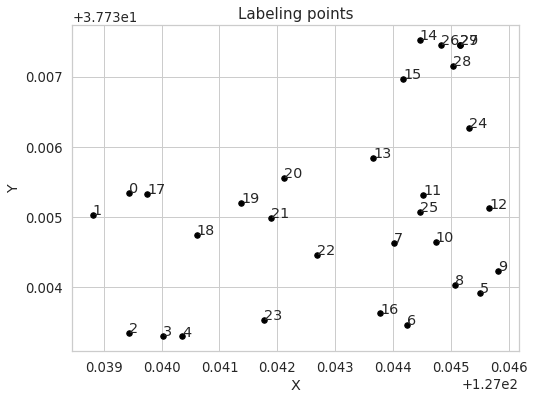

In [5]:
annotations=["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29"]

plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=30,color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Labeling points",fontsize=15)
for i, label in enumerate(annotations):
    plt.text(X[i], Y[i],label)

plt.show()

In [6]:
df = pd.read_csv('cluster(GMM) - clus 주기사.csv')
#df = df.drop(columns = ['Unnamed: 0'])
#df
df = df.to_numpy()
#df

In [7]:
df1 = pd.read_csv('cluster - clus4.csv')
df1 = df1.drop(columns = ['Unnamed: 0'])
df1 = df1.to_numpy()
df1

array([[  0, 159, 327,  83, 174, 154, 351, 448, 143],
       [159,   0, 169, 138, 222, 202, 286, 383,  57],
       [327, 169,   0, 145, 227,  73, 111, 211, 123],
       [ 83, 138, 145,   0,  82,  63, 262, 360, 138],
       [174, 222, 227,  82,   0, 147, 338, 433, 213],
       [154, 202,  73,  63, 147,   0, 176, 276, 191],
       [351, 286, 111, 262, 338, 176,   0, 100, 231],
       [448, 383, 211, 360, 433, 276, 100,   0, 335],
       [143,  57, 123, 138, 213, 191, 231, 335,   0]], dtype=int64)

In [8]:
solve_tsp_simulated_annealing(
    distance_matrix= df,
    perturbation_scheme= "two_opt",
    alpha= 0.9,
    max_processing_time = None)

([0, 10, 15, 14, 9, 2, 3, 4, 5, 17, 16, 18, 7, 8, 6, 12, 13, 11, 1], 3912)